In [1]:
#Loading all the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder,minmax_scale,PolynomialFeatures,StandardScaler,Normalizer
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
#from sklearn.model_selection import train_test_split
%matplotlib inline
import datetime
from datetime import date, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import keras
import sys
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
import lightgbm as lgb

Using TensorFlow backend.


# 3.a. Data Loading

In [2]:
#Loading the data
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

Sales = pd.read_csv('train.csv', dtype=dtypes)
#test = pd.read_csv('test.csv', dtype=dtypes)
#stores = pd.read_csv('stores.csv')
#items = pd.read_csv('items.csv')
#trans = pd.read_csv('transactions.csv')
#oil = pd.read_csv('../input/oil.csv') #we upload this database later
#holidays = pd.read_csv('holidays_events.csv')


In [3]:
#sampling the data, since the data is too huge to carry put any operations
date_mask = (Sales['date'] >= '2017-07-15') & (Sales['date'] <= '2017-08-15')

Salesdf = Sales[date_mask]

#Print the size
len(Salesdf)

3359566

# 5. Data Blending

In [4]:
test = pd.read_csv('test.csv', dtype=dtypes)
#stores = pd.read_csv('stores.csv')
items = pd.read_csv('items.csv')
#trans = pd.read_csv('transactions.csv')
#holidays = pd.read_csv('holidays_events.csv')

In [5]:
#Merge train
Salesdf = Salesdf.drop('id', axis = 1)
#Salesdf = Salesdf.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
Salesdf = Salesdf.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
#Salesdf = Salesdf.merge(holidays, left_on='date', right_on='date', how='left')
#Salesdf = Salesdf.merge(oil, left_on='date', right_on='date', how='left')

Salesdf

,date,store_nbr,item_nbr,unit_sales,onpromotion,family
0,2017-07-15,1,99197,2.0,False,GROCERY I
1,2017-07-15,1,103520,1.0,False,GROCERY I
2,2017-07-15,1,105574,6.0,False,GROCERY I
3,2017-07-15,1,105575,10.0,False,GROCERY I
4,2017-07-15,1,105737,3.0,False,GROCERY I
...,...,...,...,...,...,...
3359561,2017-08-15,54,2089339,4.0,False,GROCERY I
3359562,2017-08-15,54,2106464,1.0,True,BEVERAGES
3359563,2017-08-15,54,2110456,192.0,False,BEVERAGES
3359564,2017-08-15,54,2113914,198.0,True,CLEANING


In [6]:
Salesdf = Salesdf.drop(['onpromotion','store_nbr'], axis = 1)

In [7]:
Salesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3359566 entries, 0 to 3359565
Data columns (total 4 columns):
date          object
item_nbr      int64
unit_sales    float64
family        object
dtypes: float64(1), int64(1), object(2)
memory usage: 128.2+ MB


In [8]:
Salesdf.isnull().sum().sort_values(ascending=False)

family        0
unit_sales    0
item_nbr      0
date          0
dtype: int64

In [9]:
#Shape
print('Shape : ', Salesdf.shape, '\n')

#Type
print('Type : ', '\n', Salesdf.dtypes)

#Summary
Salesdf.describe()

Shape :  (3359566, 4) 

Type :  
 date           object
item_nbr        int64
unit_sales    float64
family         object
dtype: object


,item_nbr,unit_sales
count,3.359566e+06,3.359566e+06
mean,1.171591e+06,8.053185e+00
std,5.871905e+05,2.371664e+01
min,9.699500e+04,-2.410000e+02
25%,6.925310e+05,2.000000e+00
50%,1.212452e+06,4.000000e+00
75%,1.583407e+06,8.000000e+00
max,2.127114e+06,5.901000e+03


In [10]:
#5 random lines
Salesdf.sample(10)

,date,item_nbr,unit_sales,family
3329080,2017-08-15,1289418,1.000,GROCERY I
1373488,2017-07-28,1457202,6.000,HOME CARE
711725,2017-07-21,360705,2.000,GROCERY I
26160,2017-07-15,365264,2.000,CLEANING
1788631,2017-08-01,121964,1.000,AUTOMOTIVE
1566383,2017-07-29,1473481,8.858,PRODUCE
1595634,2017-07-30,1229625,2.000,PERSONAL CARE
1271014,2017-07-27,1913257,5.000,CLEANING
3289115,2017-08-15,750856,1.000,GROCERY I
2795312,2017-08-10,211999,2.000,GROCERY I


[Text(0, 0, 'GROCERY I'),
 Text(0, 0, 'DELI'),
 Text(0, 0, 'CLEANING'),
 Text(0, 0, 'PERSONAL CARE'),
 Text(0, 0, 'BEVERAGES'),
 Text(0, 0, 'DAIRY'),
 Text(0, 0, 'EGGS'),
 Text(0, 0, 'BREAD/BAKERY'),
 Text(0, 0, 'POULTRY'),
 Text(0, 0, 'GROCERY II'),
 Text(0, 0, 'LINGERIE'),
 Text(0, 0, 'MEATS'),
 Text(0, 0, 'FROZEN FOODS'),
 Text(0, 0, 'SEAFOOD'),
 Text(0, 0, 'LIQUOR,WINE,BEER'),
 Text(0, 0, 'HARDWARE'),
 Text(0, 0, 'LAWN AND GARDEN'),
 Text(0, 0, 'AUTOMOTIVE'),
 Text(0, 0, 'PRODUCE'),
 Text(0, 0, 'HOME AND KITCHEN II'),
 Text(0, 0, 'HOME AND KITCHEN I'),
 Text(0, 0, 'HOME CARE'),
 Text(0, 0, 'PET SUPPLIES'),
 Text(0, 0, 'CELEBRATION'),
 Text(0, 0, 'PLAYERS AND ELECTRONICS'),
 Text(0, 0, 'LADIESWEAR'),
 Text(0, 0, 'MAGAZINES'),
 Text(0, 0, 'PREPARED FOODS'),
 Text(0, 0, 'BEAUTY'),
 Text(0, 0, 'HOME APPLIANCES'),
 Text(0, 0, 'SCHOOL AND OFFICE SUPPLIES'),
 Text(0, 0, 'BABY CARE'),
 Text(0, 0, 'BOOKS')]

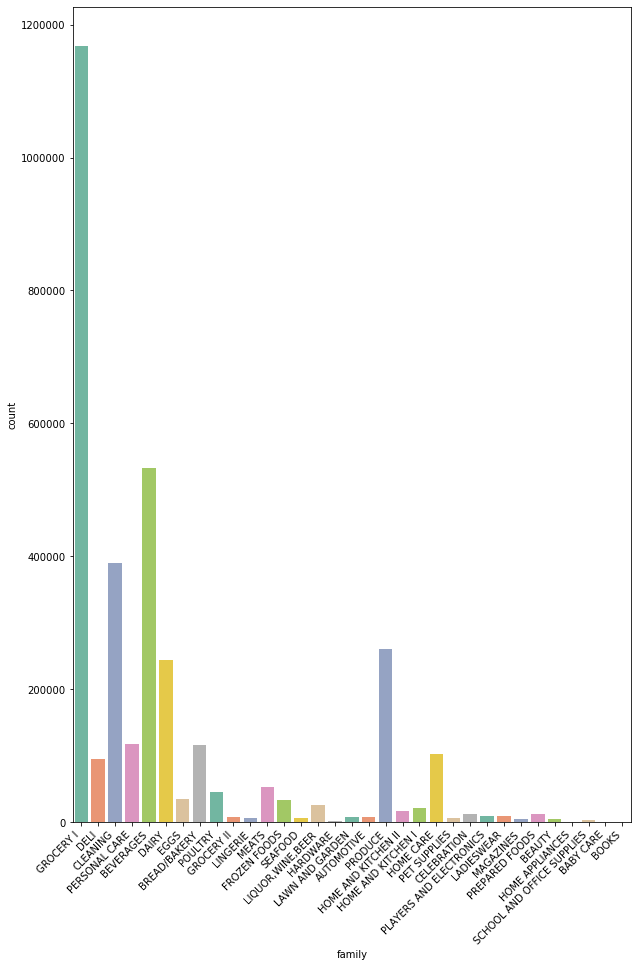

In [11]:
#sns.countplot(x='family', data=Salesdf);

plt.figure(figsize=(10,15))
chart = sns.countplot(
    data=Salesdf,
    x='family',
    palette='Set2'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# The the above plot shows the number of categories.

In [12]:
Salesdf.item_nbr.unique

<bound method Series.unique of 0            99197
1           103520
2           105574
3           105575
4           105737
            ...   
3359561    2089339
3359562    2106464
3359563    2110456
3359564    2113914
3359565    2116416
Name: item_nbr, Length: 3359566, dtype: int64>

In [13]:
x=itemfreq(Salesdf.item_nbr)
x=x[x[:,1].argsort()[::-1]]
x

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[2042947,    1726],
       [ 502331,    1724],
       [ 314384,    1723],
       ...,
       [1981370,       1],
       [1418842,       1],
       [1066900,       1]], dtype=int64)

In [14]:
x[:,0][0:10]

array([2042947,  502331,  314384,  323013,  364606,  222879, 2042941,
        414750, 1162382, 1418845], dtype=int64)

In [15]:
s=Salesdf.item_nbr.as_matrix()
s

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([  99197,  103520,  105574, ..., 2110456, 2113914, 2116416],
      dtype=int64)

In [16]:
t=s.reshape(s.shape[0],1)
t

array([[  99197],
       [ 103520],
       [ 105574],
       ...,
       [2110456],
       [2113914],
       [2116416]], dtype=int64)

In [17]:
t1=np.where(t==x)
t1

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

# 6. Product Purchase Trend

##  6.a. Fetching the N most purchased products

In [18]:
#Fetching the N most purchased products#
def N_most_labels(data, variable , N , all='TRUE'):
    labels_freq_pd = itemfreq(data[variable])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:N]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = data[variable].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_freq_pd, labels_filtered_index

label_freq, labels_filtered_index = N_most_labels(data = Salesdf, variable = "item_nbr", N = 20, all='FALSE')
print("labels_filtered_index[0].shape = ", labels_filtered_index[0].shape)

Salesdf_filtered = Salesdf.loc[labels_filtered_index[0],:]


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


labels_filtered_index[0].shape =  (34207,)


The number of most purchased products gives us the idea of looking for the sales for those products.

The code in the document by Source Kaggle is licensed under the MIT License https://opensource.org/licenses/MIT

In [19]:
label_freq[0:10]

array([[2042947,    1726],
       [ 502331,    1724],
       [ 314384,    1723],
       [ 323013,    1722],
       [ 364606,    1722],
       [ 222879,    1720],
       [2042941,    1719],
       [ 414750,    1716],
       [1162382,    1715],
       [1418845,    1715]], dtype=int64)

In [20]:
Salesdf_filtered.sample(3)

,date,item_nbr,unit_sales,family
994258,2017-07-24,1036689,10.0,GROCERY I
3243885,2017-08-14,2042941,85.0,BEVERAGES
574646,2017-07-20,1463860,34.0,BEVERAGES


In [21]:
def get_month_year(df):
    df['month'] = df.date.apply(lambda x: x.split('-')[1])
    df['year'] = df.date.apply(lambda x: x.split('-')[0])
    
    return df

get_month_year(Salesdf_filtered);

In [22]:
Salesdf_filtered['date'] = pd.to_datetime(Salesdf_filtered['date'])
Salesdf_filtered['day'] = Salesdf_filtered['date'].dt.weekday_name
Salesdf_filtered = Salesdf_filtered.drop('date', axis=1)

In [23]:
Salesdf_filtered.sample(10)

,item_nbr,unit_sales,family,month,year,day
2054310,2010511,5.0,GROCERY I,08,2017,Thursday
2739863,414750,17.0,GROCERY I,08,2017,Thursday
2532689,1052563,28.0,GROCERY I,08,2017,Monday
352788,1958216,10.0,BEVERAGES,07,2017,Tuesday
1406690,1418845,8.0,GROCERY I,07,2017,Friday
2109841,261052,13.0,GROCERY I,08,2017,Friday
1478209,265559,98.0,GROCERY I,07,2017,Saturday
17283,1162382,15.0,GROCERY I,07,2017,Saturday
2834992,2042947,109.0,BEVERAGES,08,2017,Thursday
1320412,265559,17.0,GROCERY I,07,2017,Thursday


In [24]:
strain = Salesdf.sample(frac=0.01,replace=True)

# 7. Exploratory Data Analysis

[Text(0, 0, 'GROCERY I'),
 Text(0, 0, 'DELI'),
 Text(0, 0, 'CLEANING'),
 Text(0, 0, 'PERSONAL CARE'),
 Text(0, 0, 'BEVERAGES'),
 Text(0, 0, 'DAIRY'),
 Text(0, 0, 'EGGS'),
 Text(0, 0, 'BREAD/BAKERY'),
 Text(0, 0, 'POULTRY'),
 Text(0, 0, 'GROCERY II'),
 Text(0, 0, 'LINGERIE'),
 Text(0, 0, 'MEATS'),
 Text(0, 0, 'FROZEN FOODS'),
 Text(0, 0, 'SEAFOOD'),
 Text(0, 0, 'LIQUOR,WINE,BEER'),
 Text(0, 0, 'HARDWARE'),
 Text(0, 0, 'LAWN AND GARDEN'),
 Text(0, 0, 'AUTOMOTIVE'),
 Text(0, 0, 'PRODUCE'),
 Text(0, 0, 'HOME AND KITCHEN II'),
 Text(0, 0, 'HOME AND KITCHEN I'),
 Text(0, 0, 'HOME CARE'),
 Text(0, 0, 'PET SUPPLIES'),
 Text(0, 0, 'CELEBRATION'),
 Text(0, 0, 'PLAYERS AND ELECTRONICS'),
 Text(0, 0, 'LADIESWEAR'),
 Text(0, 0, 'MAGAZINES'),
 Text(0, 0, 'PREPARED FOODS'),
 Text(0, 0, 'BEAUTY'),
 Text(0, 0, 'HOME APPLIANCES'),
 Text(0, 0, 'SCHOOL AND OFFICE SUPPLIES'),
 Text(0, 0, 'BABY CARE'),
 Text(0, 0, 'BOOKS')]

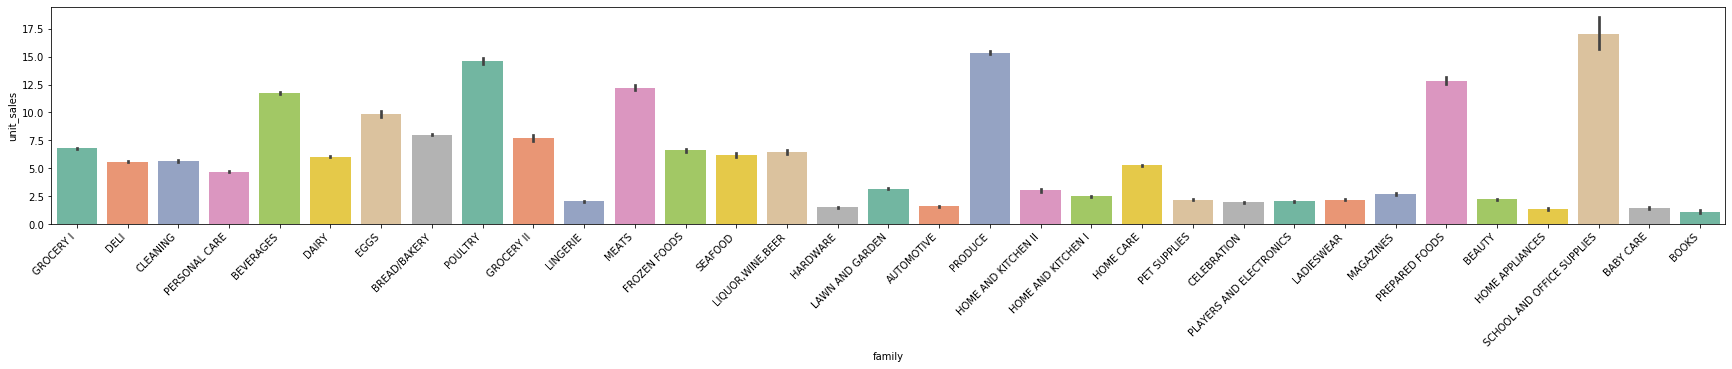

In [25]:
# Plotting Sales per Item Family
#fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
#sns.barplot(x='family', y='unit_sales', data=strain, ax=axis1)

fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
chart = sns.barplot(
    data=Salesdf,
    x='family',
    y='unit_sales',
    ax=axis1,
    palette='Set2'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# The above plot shows the sales of products per Item family. The average unit_sales ranges somewhere between 0 to 20 with the maximum.

# 8. Data Transformation Techniques

# 8.a One hot Encoding

## What is One Hot Encoding?
A one hot encoding is a representation of categorical variables as binary vectors.
This first requires that the categorical values be mapped to integer values.
Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

## Why Use a One Hot Encoding?
A one hot encoding allows the representation of categorical data to be more expressive.
Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. This is required for both input and output variables that are categorical.


## The text in the document by Source Wikipedia is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/


In [26]:
## One hot encoding using get_dummies on pandas dataframe.
dummy_variables = ['family','item_nbr','month','day']

for var in dummy_variables:
    dummy = pd.get_dummies(Salesdf_filtered[var], prefix = var, drop_first = False)
    Salesdf_filtered = pd.concat([Salesdf_filtered, dummy], axis = 1)

Salesdf_filtered = Salesdf_filtered.drop(dummy_variables, axis = 1)
Salesdf_filtered = Salesdf_filtered.drop(['year'], axis = 1)

In [27]:
Salesdf_filtered.info()
#Salesdf_filtered.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34207 entries, 112 to 3359551
Data columns (total 35 columns):
unit_sales               34207 non-null float64
family_BEVERAGES         34207 non-null uint8
family_BREAD/BAKERY      34207 non-null uint8
family_CLEANING          34207 non-null uint8
family_GROCERY I         34207 non-null uint8
family_PREPARED FOODS    34207 non-null uint8
item_nbr_222879          34207 non-null uint8
item_nbr_261052          34207 non-null uint8
item_nbr_265559          34207 non-null uint8
item_nbr_314384          34207 non-null uint8
item_nbr_323013          34207 non-null uint8
item_nbr_364606          34207 non-null uint8
item_nbr_414750          34207 non-null uint8
item_nbr_502331          34207 non-null uint8
item_nbr_581078          34207 non-null uint8
item_nbr_1036689         34207 non-null uint8
item_nbr_1052563         34207 non-null uint8
item_nbr_1157564         34207 non-null uint8
item_nbr_1162382         34207 non-null uint8
item_nbr_14

In [28]:
Salesdf_filtered.head()

,unit_sales,family_BEVERAGES,family_BREAD/BAKERY,family_CLEANING,family_GROCERY I,family_PREPARED FOODS,item_nbr_222879,item_nbr_261052,item_nbr_265559,item_nbr_314384,...,item_nbr_2081064,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
112,4.0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
131,6.0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
147,26.0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
180,35.0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
204,6.0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


# The above dataframe contains data after the one hot encoding technique is applied to the data.

In [29]:
#Re-scale
#We keep this value to re-scale the predicted unit_sales values in the following lines of code.
min_train, max_train = Salesdf_filtered['unit_sales'].min(), Salesdf_filtered['unit_sales'].max()

In [30]:
scalable_variables = ['unit_sales']

for var in scalable_variables:
    mini, maxi = Salesdf_filtered[var].min(), Salesdf_filtered[var].max()
    Salesdf_filtered.loc[:,var] = (Salesdf_filtered[var] - mini) / (maxi - mini)

In [31]:
print('Shape : ', Salesdf_filtered.shape)
Salesdf_filtered.sample(10)

Shape :  (34207, 35)


,unit_sales,family_BEVERAGES,family_BREAD/BAKERY,family_CLEANING,family_GROCERY I,family_PREPARED FOODS,item_nbr_222879,item_nbr_261052,item_nbr_265559,item_nbr_314384,...,item_nbr_2081064,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
2865611,0.007845,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3047692,0.010460,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2985562,0.006799,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1389083,0.008368,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3236454,0.041318,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
1951905,0.012029,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
326389,0.007845,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
183894,0.005753,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1499432,0.015690,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2228269,0.021444,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [32]:
Salesdf_filtered.isnull().sum()


unit_sales               0
family_BEVERAGES         0
family_BREAD/BAKERY      0
family_CLEANING          0
family_GROCERY I         0
family_PREPARED FOODS    0
item_nbr_222879          0
item_nbr_261052          0
item_nbr_265559          0
item_nbr_314384          0
item_nbr_323013          0
item_nbr_364606          0
item_nbr_414750          0
item_nbr_502331          0
item_nbr_581078          0
item_nbr_1036689         0
item_nbr_1052563         0
item_nbr_1157564         0
item_nbr_1162382         0
item_nbr_1418845         0
item_nbr_1463860         0
item_nbr_1958216         0
item_nbr_2010511         0
item_nbr_2042941         0
item_nbr_2042947         0
item_nbr_2081064         0
month_07                 0
month_08                 0
day_Friday               0
day_Monday               0
day_Saturday             0
day_Sunday               0
day_Thursday             0
day_Tuesday              0
day_Wednesday            0
dtype: int64

In [33]:
#train database without unit_sales
Salesdf_filtered = Salesdf_filtered.reset_index(drop=True)  #we reset the index
y = Salesdf_filtered['unit_sales']
X = Salesdf_filtered.drop(['unit_sales'], axis = 1)

print('Shape X :', X.shape)
print('Shape y :', y.shape)

Shape X : (34207, 34)
Shape y : (34207,)


In [34]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test, random_state=15)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (27365, 34)
y_train shape : (27365,)
X_test shape : (6842, 34)
y_test shape : (6842,)


# 9. Regression Model fitting techniques.

# 9.a. Linear Regression

## Linear Regression

Linear Regression is a linear approach for modelling the relationship between a scalar dependent variable y and one or more explanatory variables (or independent variables) denoted X. The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression.

Linear regression models are often fitted using the least squares approach, but they may also be fitted in other ways, such as by minimizing the "lack of fit" in some other norm (as with least absolute deviations regression), or by minimizing a penalized version of the least squares cost function as in ridge regression (L2-norm penalty) and lasso (L1-norm penalty). 


## The text in the document by Source Wikipedia is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

In [35]:
# Fit the linear model
model = linear_model.LinearRegression()
results = model.fit(X_train, y_train)
print(results)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [36]:
# Print the coefficients
print (results.intercept_, results.coef_)

11149572851.287153 [ 3.64610270e+09 -4.03766297e+07 -8.01000221e+08 -1.51957120e+09
 -7.88989384e+08 -1.00587423e+08 -1.00587423e+08 -1.00587423e+08
 -1.00587423e+08 -1.00587423e+08 -1.00587423e+08 -1.00587423e+08
 -1.57978199e+09 -8.19158403e+08 -1.00587423e+08 -1.00587423e+08
 -1.00587423e+08 -1.00587423e+08 -1.00587423e+08 -5.26626132e+09
 -5.26626132e+09 -1.00587423e+08 -5.26626132e+09 -5.26626132e+09
 -8.31169240e+08 -7.69603868e+09 -7.69603868e+09 -1.83337555e+09
 -1.83337555e+09 -1.83337555e+09 -1.83337555e+09 -1.83337555e+09
 -1.83337555e+09 -1.83337555e+09]


In [37]:
import statsmodels.api as sm
import statsmodels.regression.linear_model as sm
model = sm.OLS(y_train, X_train)
results = model.fit()
# Statsmodels gives R-like statistical output
results.summary()
# Here the Ordinalry Least Squares method has given us the r^2 value of 0.354 which is poor for model to be predicted on these variables.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             unit_sales   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     295.6
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:57:44   Log-Likelihood:                 63085.
No. Observations:               27365   AIC:                        -1.261e+05
Df Residuals:                   27338   BIC:                        -1.259e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
family_BEVERAGES       2.654e+10   4.25e+10      0.625      0.532   -5.67e+10     1.1e+11
family_BREAD/BAKERY    4.843e+09   6.56e+09      0.739      0.460   -8.01e+09    1.77e+10
family_CLEANING        4.755e+09   6.43e+09      0.740      0.459   -7.84e+09    1.73e+10
family_GROCERY I       2.953e+09   1.25e+10      0.237      0.813   -2.15e+10    2.74e+10
family_PREPARED FOODS  4.917e+09   6.69e+09      0.735      0.462    -8.2e+09     1.8e+10
item_nbr_222879        6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_261052        6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_265559        6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_314384        6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_323013        6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_364606        6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_414750        6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_502331        4.899e+09   6.55e+09      0.748      0.455   -7.95e+09    1.77e+10
item_nbr_581078        4.987e+09   6.69e+09      0.745      0.456   -8.13e+09    1.81e+10
item_nbr_1036689       6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_1052563       6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_1157564       6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_1162382       6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_1418845       6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_1463860       -1.68e+10   4.05e+10     -0.415      0.678   -9.62e+10    6.26e+10
item_nbr_1958216       -1.68e+10   4.05e+10     -0.415      0.678   -9.62e+10    6.26e+10
item_nbr_2010511       6.789e+09    5.9e+09      1.151      0.250   -4.77e+09    1.83e+10
item_nbr_2042941       -1.68e+10   4.05e+10     -0.415      0.678   -9.62e+10    6.26e+10
item_nbr_2042947       -1.68e+10   4.05e+10     -0.415      0.678   -9.62e+10    6.26e+10
item_nbr_2081064       4.826e+09   6.42e+09      0.751      0.452   -7.76e+09    1.74e+10
month_07              -2.948e+09   1.25e+10     -0.237      0.813   -2.74e+10    2.15e+10
month_08              -2.948e+09   1.25e+10     -0.237      0.813   -2.74e+10    2.15e+10
day_Friday            -6.794e+09   1.56e+10     -0.435      0.663   -3.74e+10    2.38e+10
day_Monday            -6.794e+09   1.56e+10     -0.435      0.663   -3.74e+10    2.38e+10
day_Saturday          -6.794e+09   1.56e+10     -0.435      0.663   -3.74e+10    2.38e+10
day_Sunday            -6.794e+09   1.56e+10     -0.435      0.663   -3.74e+10    2.38e+10
day_Thursday          -

# The Linear regression model gives a low R- square value of 0.219

## Checking for VIF for eliminating multicollinearity and overfitting

In [44]:
#Implementing VIF (Variance Inflation Factor) to check whether the selected independent variables are correct for prediction 
# or not. Also, 'item_nbr', 'perishable' and 'dcoilwtico' had very close levels of co-relation with price which makes us to investigate whether all 
# three are important or not.
indep=['item_nbr']
X=Salesdf[indep]

In [45]:
Salesdf

,date,item_nbr,unit_sales,family
0,2017-07-15,99197,2.0,GROCERY I
1,2017-07-15,103520,1.0,GROCERY I
2,2017-07-15,105574,6.0,GROCERY I
3,2017-07-15,105575,10.0,GROCERY I
4,2017-07-15,105737,3.0,GROCERY I
...,...,...,...,...
3359561,2017-08-15,2089339,4.0,GROCERY I
3359562,2017-08-15,2106464,1.0,BEVERAGES
3359563,2017-08-15,2110456,192.0,BEVERAGES
3359564,2017-08-15,2113914,198.0,CLEANING


In [48]:
X=Salesdf[['item_nbr','family']]
y=Salesdf[["unit_sales"]]

## Cross Validation using Scikit Learn

R^2 value is basically dependant on the way the data is split. Hence, there may be times when the R^2 value may not be able to
represent the model's ability to generalize. For this we perform cross validation.

In [49]:
reg=linear_model.LinearRegression()
cv_results=cross_val_score(reg,X_train,y_train,cv=5)
print(cv_results)
print(np.mean(cv_results))
print(np.std(cv_results))
#Using cross validation of score 5

[0.28633946 0.18162514 0.2108504  0.21535829 0.21947609]
0.22272987604751796
0.03447267877818303


## Regularization

We perform regularization in order to alter the loss function to penalize it for having higher coefficients for each feature variable. And as we know, large coefficients leads to overfitting.

In [50]:
ridge = Ridge(alpha=0.1, normalize = True)
ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test)
ridge.score(X_test,y_test)
#The score is pretty much similar to the linear model built which ensures that the model has passed the Ridge regression test
# for regularization
#Ridge is used to penalize the loss function by adding the OLS loss function to the square of each coefficient multiplied by alpha.

0.1874972439549862

## 9.b DecisionTree Regressor

A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.



In [51]:
dtr=DecisionTreeRegressor(max_depth=10,min_samples_leaf=5,max_leaf_nodes=5)

In [52]:
dtr.fit(X_train,y_train)
y_pred=dtr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

##using a decision tree greatly improves the accurancy of model prediction.

R2 score =  0.18293760990367458 / 1.0
MSE score =  0.0007576048207479044 / 0.0


## 9.c. ExtraTreesRegressor

Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen.

In [53]:
etr = ExtraTreesRegressor()

# Choose some parameter combinations to try

parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }
#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold

grid_obj = GridSearchCV(etr, parameters,
                        cv=3, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
etr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
etr.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   41.0s finished


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=15, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=5, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [54]:
y_pred = etr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.23849422187793212 / 1.0
MSE score =  0.0007060910592943192 / 0.0


## 9.d Random Forest Regressor

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.Random decision forests correct for decision trees' habit of overfitting to their training set.

In [55]:
# Choose the type of classifier. 
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5, 10, 100],
              'min_samples_leaf': [1,5]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [56]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.23782879462948825 / 1.0
MSE score =  0.000706708063451393 / 0.0


In [57]:
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   46.2s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.23928139128515824 / 1.0
MSE score =  0.0007053611721463017 / 0.0


## 9.e. Gradient Boosting Regressor

The idea of boosting came out of the idea of whether a weak learner can be modified to become better.
A weak hypothesis or weak learner is defined as one whose performance is at least slightly better than random chance.
Hypothesis boosting was the idea of filtering observations, leaving those observations that the weak learner can handle and focusing on developing new weak learns to handle the remaining difficult observations.

## How Gradient Boosting Works

Gradient boosting involves three elements:

-- A loss function to be optimized.

-- A weak learner to make predictions.

-- An additive model to add weak learners to minimize the loss function.

In [59]:
#gbr = GradientBoostingRegressor(loss='huber',learning_rate=0.3,n_estimators=100,max_depth=5,min_samples_split=3)
gbr=GradientBoostingRegressor()

parameters = {'n_estimators': [5,10],
              'loss':['huber'],
              'criterion': ['mse'],
              'max_depth': [5,10], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  69 out of  80 | elapsed:    4.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.8s finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [60]:
y_pred = gbr.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using Gradient Boosting= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using Gradient Boosting=  0.1081191650790353 / 1.0
MSE score using Gradient Boosting=  0.0008269787329081806 / 0.0


In [61]:
gbr = GradientBoostingRegressor(loss='ls',learning_rate=0.1,n_estimators=150,max_depth=10,min_samples_split=5)


parameters = {'n_estimators': [5,15,150],
              'loss':['ls','huber'],
              'criterion': ['mse'],
              'max_depth': [10,15], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.1min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [62]:
y_pred = RFR.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using Gradient Boosting= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using Gradient Boosting=  0.23928139128515824 / 1.0
MSE score using Gradient Boosting=  0.0007053611721463017 / 0.0


## 9.f. XGBOOST

XGBoost (eXtreme Gradient Boosting) is a direct application of Gradient Boosting for decision trees

Main advantages are as follows:
1. Easy to use
2. Computational efficiency
3. Model Accuracy
4. Feasibility — easy to tune parameters and modify objectives.

In [63]:
model=XGBRegressor(max_depth=5)

In [64]:
model.fit(X_train,y_train)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:40:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [65]:
y_pred=model.predict(X_test)

In [66]:
print('R2 score using XG Boost= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using XG Boost= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using XG Boost=  0.23708236773945168 / 1.0
MSE score using XG Boost=  0.0007074001729121661 / 0.0


## 10. LGBM

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. 

In [67]:

from lightgbm import LGBMRegressor
lgbm=LGBMRegressor(max_depth=5)
lgbm.fit(X_train,y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
y_pred=lgbm.predict(X_test)

In [69]:
print('R2 score using LGBM = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using LGBM = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using LGBM =  0.23807252158302628 / 1.0
MSE score using LGBM =  0.0007064820724901337 / 0.0


In [70]:
Salesdf.corr()


,item_nbr,unit_sales
item_nbr,1.000000,0.024456
unit_sales,0.024456,1.000000


## 11. Creating a neural network

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function  by training on a dataset, where  is the number of dimensions for input and  is the number of dimensions for output.

The advantages of Multi-layer Perceptron are:

-- Capability to learn non-linear models.

-- Capability to learn models in real-time (on-line learning) using partial_fit.

In [71]:
# Convert data as np.array
features = np.array(X_train)
#targets = np.array(y_train.reshape(y_train.shape[0],1))
targets = np.array(y_train.values.reshape(y_train.shape[0],1))
features_validation= np.array(X_test)
#targets_validation = np.array(y_test.reshape(y_test.shape[0],1))
targets_validation = np.array(y_test.values.reshape(y_test.shape[0],1))

print(features[:10])
print(targets[:10])

[[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0]]
[[0.02301255]
 [0.01046025]
 [0.00679916]
 [0.01202929]
 [0.0083682 ]
 [0.00889121]
 [0.02196653]
 [0.01464435]
 [0.00627615]
 [0.00941423]]


In [72]:
# Building the model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(1))

# Compiling the model
model.compile(loss = 'mse', optimizer='adam', metrics=['mse']) #mse: mean_square_error
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


Step :  0 / 1000
27365/27365 [==============================] - 0s 11us/step
Training MSE: 0.0005626619677059352
6842/6842 [==============================] - 0s 10us/step
Validation MSE: 0.0007272682269103825 

Step :  250 / 1000
27365/27365 [==============================] - 0s 9us/step
Training MSE: 0.0005528208566829562
6842/6842 [==============================] - 0s 9us/step
Validation MSE: 0.000706100428942591 

Step :  500 / 1000
27365/27365 [==============================] - 0s 9us/step
Training MSE: 0.0005639371811412275
6842/6842 [==============================] - 0s 10us/step
Validation MSE: 0.0007303226739168167 

Step :  750 / 1000
27365/27365 [==============================] - 0s 11us/step
Training MSE: 0.000556175597012043
6842/6842 [==============================] - 0s 15us/step
Validation MSE: 0.0007121972157619894 



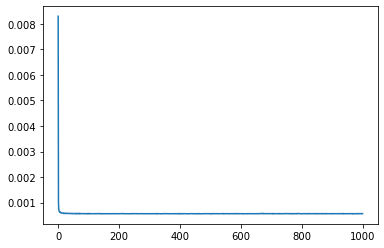

In [73]:
# Training the model
epochs_tot = 1000
epochs_step = 250
epochs_ratio = int(epochs_tot / epochs_step)
hist =np.array([])

for i in range(epochs_ratio):
    history = model.fit(features, targets, epochs=epochs_step, batch_size=100, verbose=0)
    
    # Evaluating the model on the training and testing set
    print("Step : " , i * epochs_step, "/", epochs_tot)
    score = model.evaluate(features, targets)
    print("Training MSE:", score[1])
    score = model.evaluate(features_validation, targets_validation)
    print("Validation MSE:", score[1], "\n")
    hist = np.concatenate((hist, np.array(history.history['mse'])), axis = 0)#mse: mean_square_error
    
# plot metrics
plt.plot(hist)
plt.show()

In [74]:
y_pred = model.predict(features_validation, verbose=0)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.2319089168516173 / 1.0
MSE score =  0.0007121971521637308 / 0.0


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


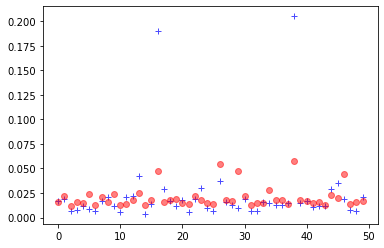

In [75]:
#Lets plot the  first 50 predictions
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()